In [1]:
# Transfer learning tutorial by PyTorch

# Two methods for learning using pretrained model:
# 1. Fine-Tuning the ConvNet - Initialize pretrained model, then fine-tune on specific image dataset
# 2. Fixed Feature Extractor - Freeze ConvNet except for last connected layer, which gets randomly initialized weights
# and is then trained on dataset. Only final layer is trained on new dataset. 

# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize some images

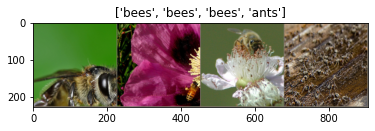

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Here we have a function that trains the model. We schedule the learning rate and save the best model 

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualize model predictions
Below we have a function that displays the predictions for a few images

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet
Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset

Here we load the pretrained ConvNet model and reset the final fully connected layer (Transfer learning??)

This pretrained model is the ResNet18 model from the paper "Deep Residual Learning for Image Recognition". 

### Paper abstract:
"Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. We also present analysis on CIFAR-10 with 100 and 1000 layers.
The depth of representations is of central importance for many visual recognition tasks. Solely due to our extremely deep representations, we obtain a 28% relative improvement on the COCO object detection dataset. Deep residual nets are foundations of our submissions to ILSVRC & COCO 2015 competitions, where we also won the 1st places on the tasks of ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation."


In [9]:
# SSL certificate is invalid?? Not sure what this means but couldn't grab the pretrained model so used this as workaround
# Bypasses SSL certificate?
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Using 
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/noahigram/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


## Train and Evaluate!
Taking awhile on CPU so try GPU? 

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6622 Acc: 0.6844
val Loss: 0.2105 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.3955 Acc: 0.8443
val Loss: 0.2715 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4033 Acc: 0.8320
val Loss: 0.3884 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.6303 Acc: 0.7295
val Loss: 0.4217 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.4329 Acc: 0.8238
val Loss: 0.2211 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.5810 Acc: 0.7623
val Loss: 0.7599 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.6285 Acc: 0.7664
val Loss: 0.2600 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3367 Acc: 0.8566
val Loss: 0.2196 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2778 Acc: 0.8730
val Loss: 0.2140 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3043 Acc: 0.8689
val Loss: 0.1881 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3588 Acc: 0.8648
val Loss: 0.1879 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2956 Acc: 0.8934
val Loss: 0.1960 Acc: 0.9412

Ep

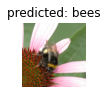

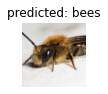

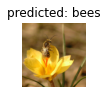

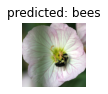

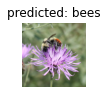

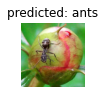

In [11]:
visualize_model(model_ft)

## ConvNet as a fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward()

In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and Evaluate 
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5759 Acc: 0.7049
val Loss: 0.2396 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4486 Acc: 0.7992
val Loss: 0.1808 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4497 Acc: 0.7828
val Loss: 0.1542 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.5544 Acc: 0.7869
val Loss: 0.1548 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.3814 Acc: 0.8279
val Loss: 0.1708 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4598 Acc: 0.7869
val Loss: 0.1792 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3633 Acc: 0.8361
val Loss: 0.2231 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.2933 Acc: 0.8770
val Loss: 0.1683 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3577 Acc: 0.8607
val Loss: 0.1673 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3634 Acc: 0.8443
val Loss: 0.1695 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3321 Acc: 0.8443
val Loss: 0.1887 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4248 Acc: 0.8033
val Loss: 0.1616 Acc: 0.9608

Ep

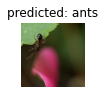

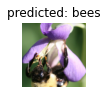

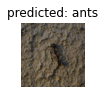

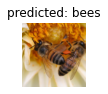

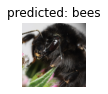

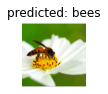

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on Custom Images

In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

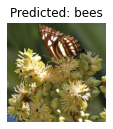

In [16]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()